In [3]:
import numpy as np
from shapely.geometry import Polygon
from cvt_bfgs import *
from wavenumers_bfgs import *
from numerical_test_gradients import *

In [8]:
def plot_gradient_error(f, grad_f, x, args = (), **kwargs):
    n = 10
    exponents = np.linspace( -7, -1, n) # exponents of the steps h
    h = 10**(exponents) # the steps
    errors = np.zeros(n)
    errors2 = np.copy(errors)
    errors3 = np.copy(errors)
    errors4 = np.copy(errors)
    for i in range(n):
        errors[i] = numerical_test_gradient_coordinates(f, grad_f, x, h = h[i], args = args)
        errors2[i] = numerical_test_gradient_coordinates(f, grad_f, x, h = h[i], args = args, order = 2)
        #errors3[i] = numerical_test_gradient_directional(f, grad_f, x, h = h[i], args = args)
        #errors4[i] = numerical_test_gradient_directional(f, grad_f, x, h = h[i], args = args, order = 2)
    plt.figure(figsize = (10, 10))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.loglog(h, errors, label = "1st order scheme")
    ax.loglog(h, h, label = "$h$")
    ax.loglog(h, errors2, label = "2nd order scheme")
    ax.loglog(h, h**2, label = "$h^2$")
    #ax.loglog(h, errors3, label = "directional derivative, 1st order")
    #ax.loglog(h, errors4, label = "directional derivative, 2nd order")
    if 'title' in kwargs.keys():
        plt.title(kwargs['title'])
    plt.legend()
    plt.show()

In [5]:
# Data wavenumbers 
x_diffraction_pt = np.array([5000, -3000]) # difraction point, fixed throughout the notebook

start = 0
stop = 10000

c0 = 2*np.pi # velocity of the medium
#c0 = 1
f0 = 1 
k0 = 2*np.pi*f0/c0

# We compute the maximum angle \phi_max that \phi_s and \phi_r can take; will be useful for 
# later angular and circular arcs formulations of the wavenumber components 
s_limits = np.array([stop, 0])
ps_limits = x_diffraction_pt - s_limits
ps_limits = ps_limits/np.linalg.norm(ps_limits)

phi_max = np.arccos(np.inner(ps_limits, np.array([0, -1]))) # maximum angle
phi_limits = np.array([- phi_max, phi_max]) # boundaries of the angles
limits, empty = angles2layout(phi_limits, np.array([]), x_diffraction_pt) # boundaries on the subsurface
phi_max_enveloppe = phi_max + 0.1 # maximum angle of the wavenumbers domain
phi_limits_enveloppe = np.array([- phi_max_enveloppe, phi_max_enveloppe]) # boundaries of the angles (wavenumbers domain)

m = 6 # number of sources
n = 6 # number of receivers
# We can use bounds for L-BFGS-B ( the method tends to produce errors)
Bounds = [ np.array([-phi_max, phi_max]) for i in range(n + m)] # Initialization wavenumbers

Domain = domain_construction( phi_limits_enveloppe, k0)

# Numerical test of the gradients
Always check the gradient, who knows if you didn't make a mistake.

## CVT objective function

### Square

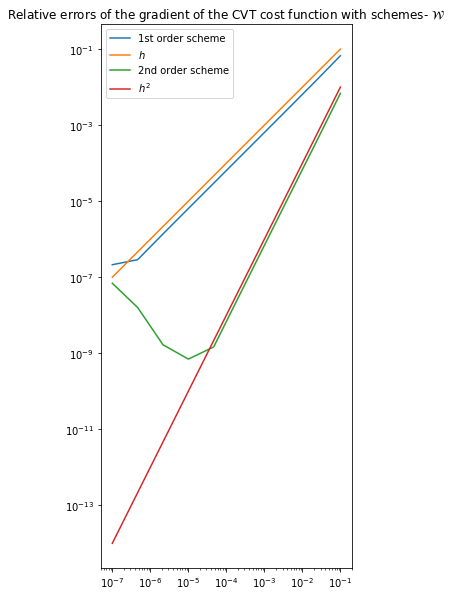

In [9]:
square = np.array([[0,0], [4,0], [4,4], [0,4]])
title = "Relative errors of the gradient of the CVT cost function with schemes- $\mathcal{W}$"
X = np.random.uniform(0, 4, size = (6, 2)).flatten()
plot_gradient_error(F, grad_F, X, args = (square,), title = title)

### Hectagon

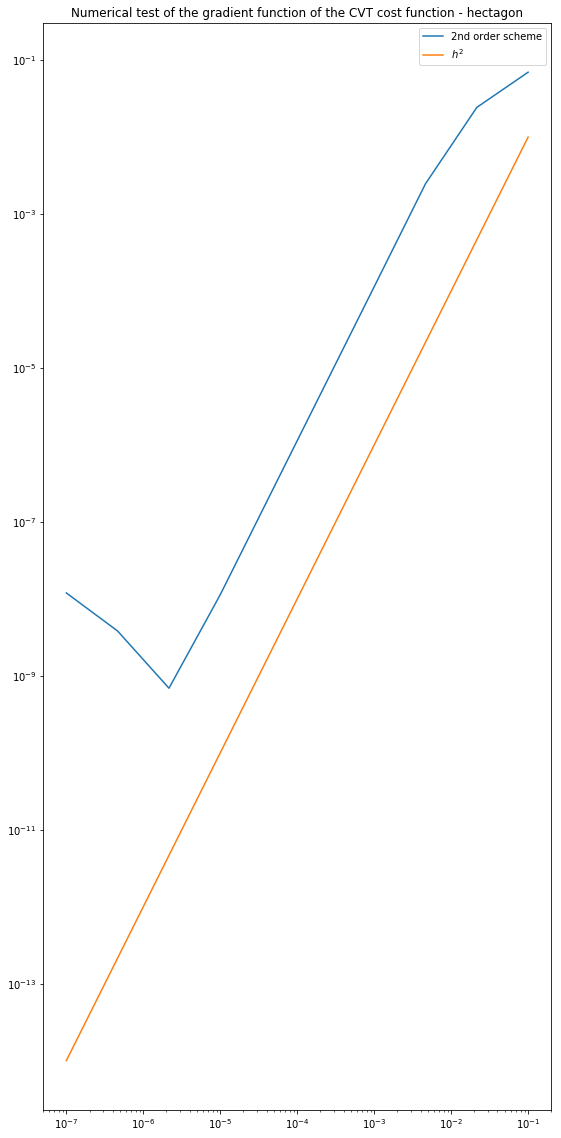

In [5]:
x = 3/np.sqrt(2)
y = 3

hectagon = np.array([[0, y], [x, x], [y, 0], [x, -x], [0, -y], [-x, -x], [-y, 0], [-x, x]])
nb_pts = 9
angles = np.random.uniform(0, 2*np.pi, nb_pts)
radii = np.random.uniform(0, y, nb_pts)
centroid = list(Polygon(hectagon).centroid.coords)
X = centroid + np.array([ [r*np.cos(theta), r*np.sin(theta)] for theta, r in zip(angles, radii) ])
X = X.flatten()

title = "Numerical test of the gradient function of the CVT cost function - hectagon"
plot_gradient_error(F, grad_F, X, args = (hectagon,), title = title)

### Circle

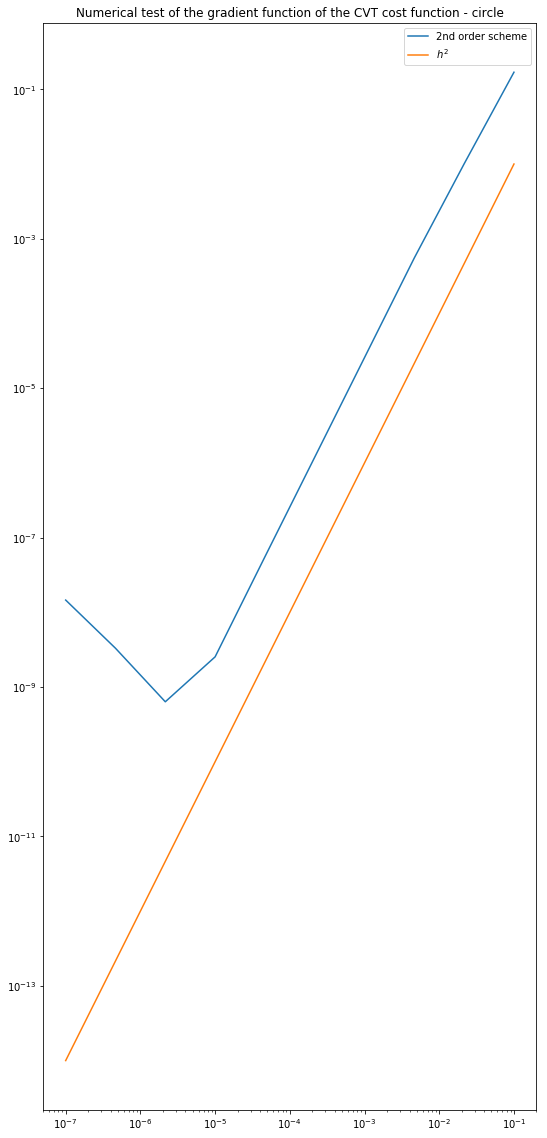

In [7]:
center = np.array([0,0])
radius = 4
angles = np.linspace(0, 2*np.pi, num = 360, endpoint = False)
Circle = radius*np.array([ [np.cos(a), np.sin(a)] for a in angles])

nb_pts = 10
angles = np.random.uniform(0, 2*np.pi, nb_pts)
radii = np.random.uniform(0, radius, nb_pts)
X = center + np.array([ [r*np.cos(theta), r*np.sin(theta)] for theta, r in zip(angles, radii) ])
seeds, cells = voronoi_domain(X, Circle)
#plot_voronoi_domain(seeds, Circle, cells)

title = "Numerical test of the gradient function of the CVT cost function - circle"
plot_gradient_error(F, grad_F, X.flatten(), args = (Circle,), title = title)

### Half-Circle

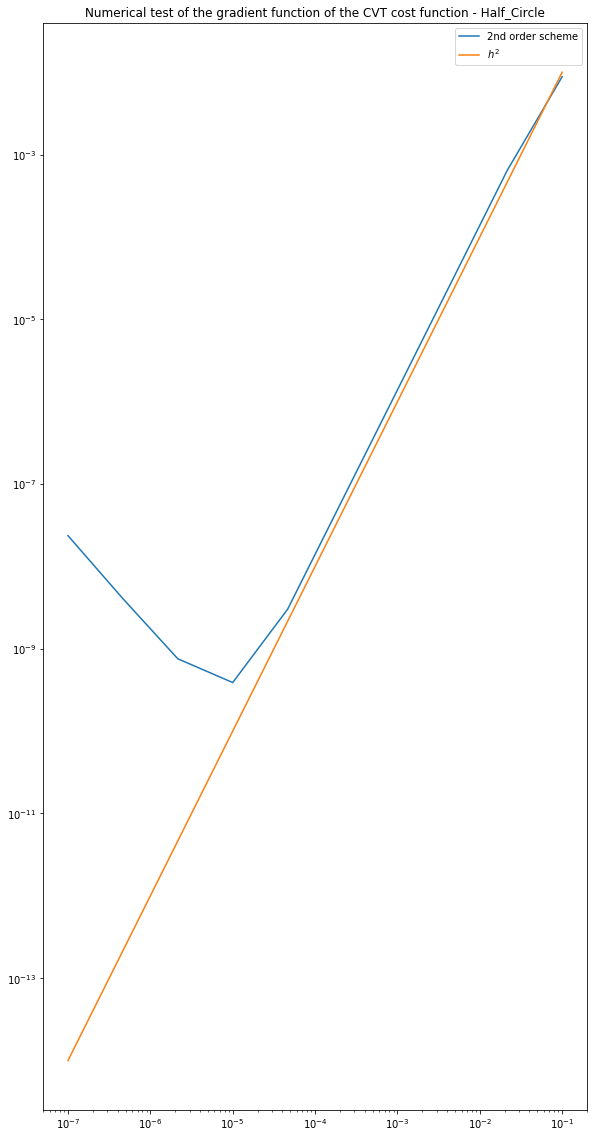

In [8]:
center = np.array([0,0])
radius = 4
angles = np.linspace(0, -np.pi, num = 360, endpoint = False)
Half_Circle = radius*np.array([ [np.cos(a), np.sin(a)] for a in angles])

nb_pts = 10
angles = np.random.uniform(0, -np.pi, nb_pts)
radii = np.random.uniform(0, radius, nb_pts)
X = center + np.array([ [r*np.cos(theta), r*np.sin(theta)] for theta, r in zip(angles, radii) ])
seeds, cells = voronoi_domain(X, Half_Circle)
#plot_voronoi_domain(seeds, Half_Circle, cells)

title = "Numerical test of the gradient function of the CVT cost function - Half_Circle"
plot_gradient_error(F, grad_F, X.flatten(), args = (Half_Circle,), title = title)

### L

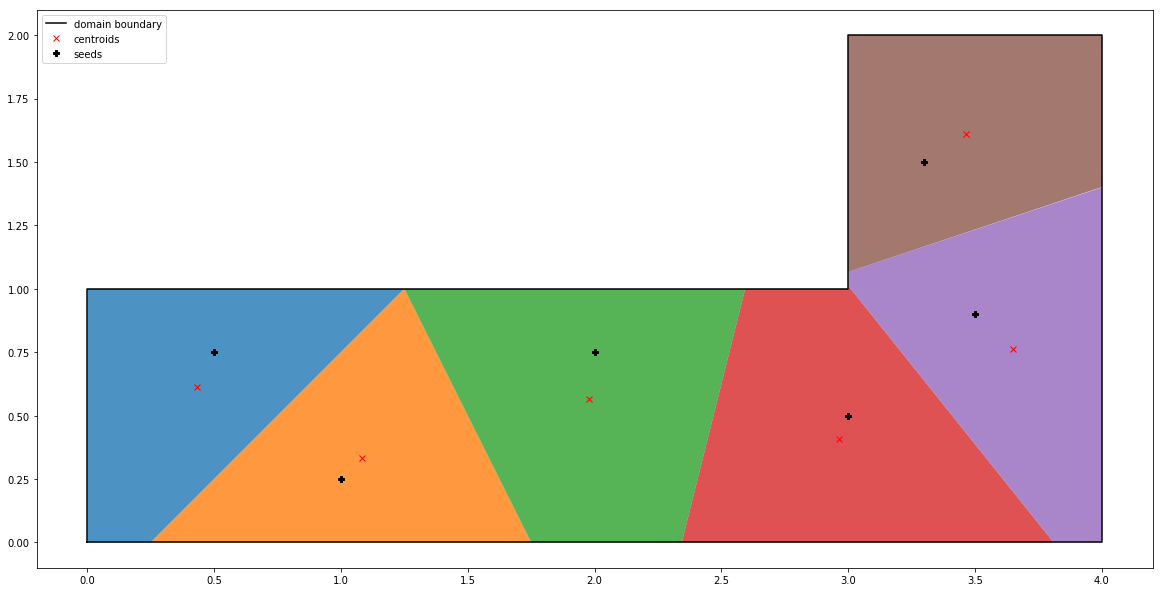

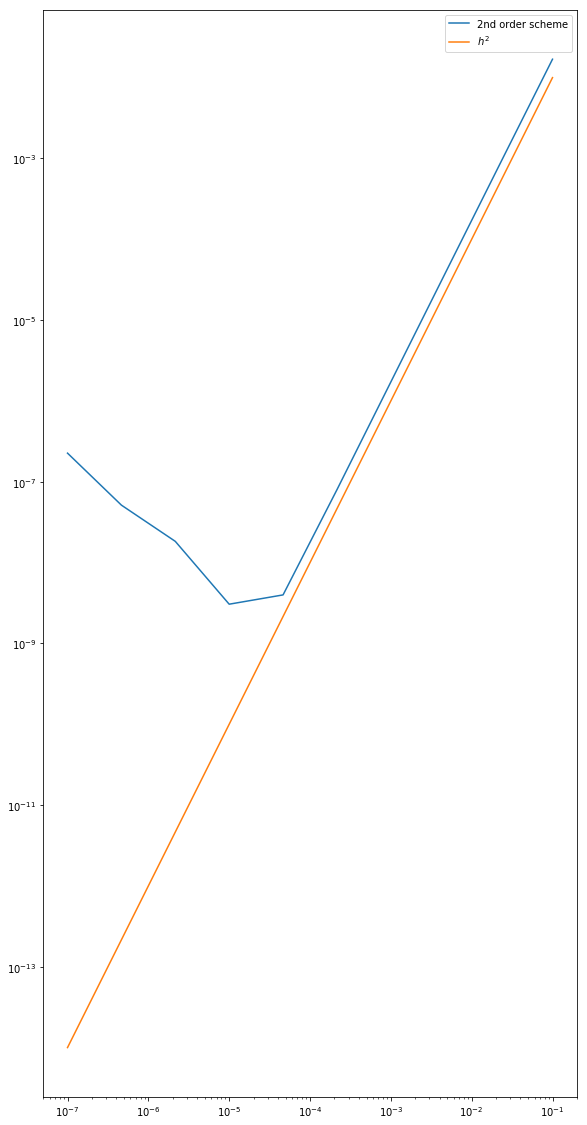

In [9]:
L = np.array([[0,0], [0, 1], [3, 1], [3, 2], [4, 2], [4, 0]])
initial_L = np.array([[0.5, 0.75], [1, 0.25], [2, 0.75], [3, .5], [3.5, 0.9], [3.3, 1.5]])

seeds, regions = voronoi_domain(initial_L, L)
plot_voronoi_domain(seeds, L, regions)
plot_gradient_error(F, grad_F, initial_L.flatten(), args = (L,))

### Wavenumbers domain

#### random seeds

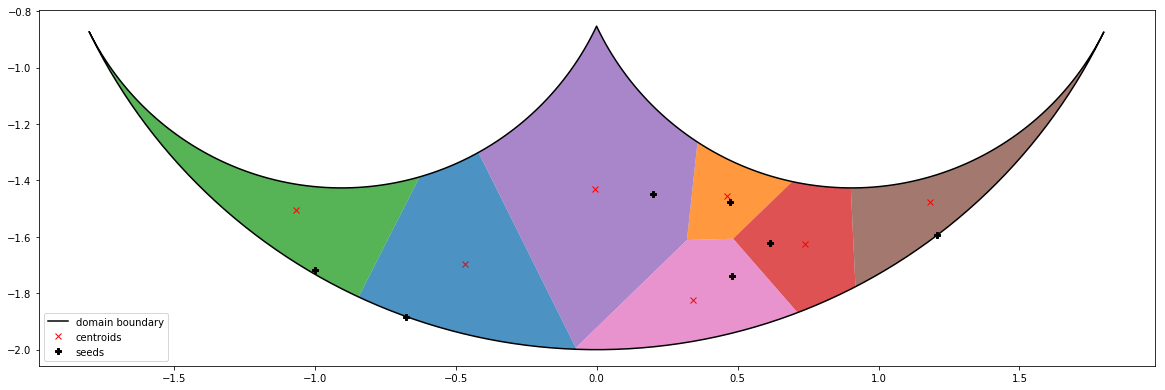

In [10]:
# random seeds
nb_seeds = 7
initial_Phi = np.random.uniform(- phi_max, phi_max, size = (nb_seeds,2))
initial_K = []
for angles in initial_Phi:
    phis = angles[0]
    phir = angles[1]
    k = wavenumber_angular_formula(phis, phir, k0)
    initial_K.append(k)
initial_K = np.array(initial_K).reshape(nb_seeds, 2)
K = initial_K.reshape(nb_seeds, 2).flatten() # the poinst at which we test the gradient

#plot_scatter(initial_K, "Reference", title = "Reference cloud obtained using the example", color = 'k')
seeds, cells = voronoi_domain(K, Domain)
plot_voronoi_domain(seeds, Domain, cells)

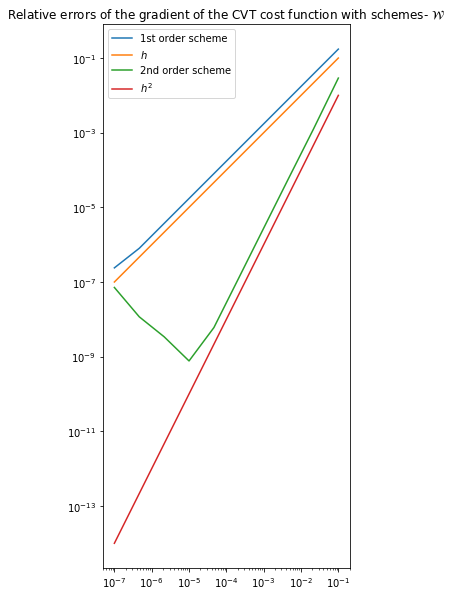

In [11]:
title = "Relative errors of the gradient of the CVT cost function with schemes- $\mathcal{W}$"
plot_gradient_error(F, grad_F, K, args = (Domain,), title = title)

#### regular angles

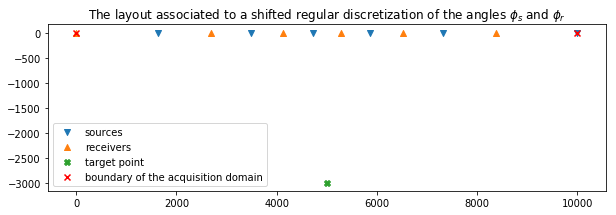

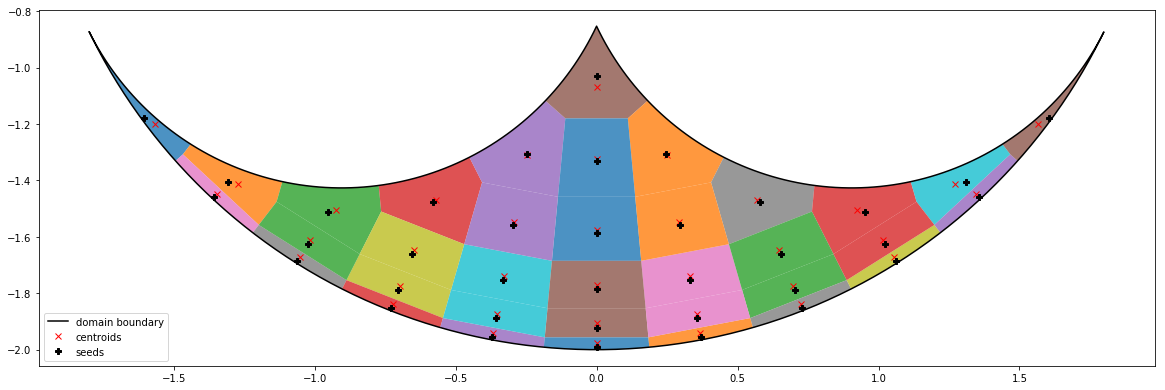

In [13]:
Phi = np.linspace(start = -phi_max, stop = phi_max, num = n + m)
phiS_regular_shifted = Phi[0::2]
phiR_regular_shifted = Phi[1::2]

S_regular_shifted, R_regular_shifted = angles2layout(phiS_regular_shifted, phiR_regular_shifted, x_diffraction_pt)

plot_disposition(S_regular_shifted, R_regular_shifted, x_diffraction_pt, title = "The layout associated to a shifted regular discretization of the angles $\phi_s$ and $\phi_r$", limits = limits)

# We compute the wavenumbers components of reference
K_regular_shifted = wavenumbers_components(x_diffraction_pt, S_regular_shifted, R_regular_shifted, c0, f0, method = "132_modified")
#plot_scatter(K_regular_shifted, "Regular phi_s and phi_r (Shifted) ", title = "with regular discretization of the angles space (Shifted).", color = 'steelblue')
seeds, regions = voronoi_domain(K_regular_shifted, Domain)
plot_voronoi_domain(seeds, Domain, regions)

# Choose which acquisition to select as initialization
initial_Phi = np.concatenate((phiS_regular_shifted, phiR_regular_shifted))

K = K_regular_shifted.flatten()

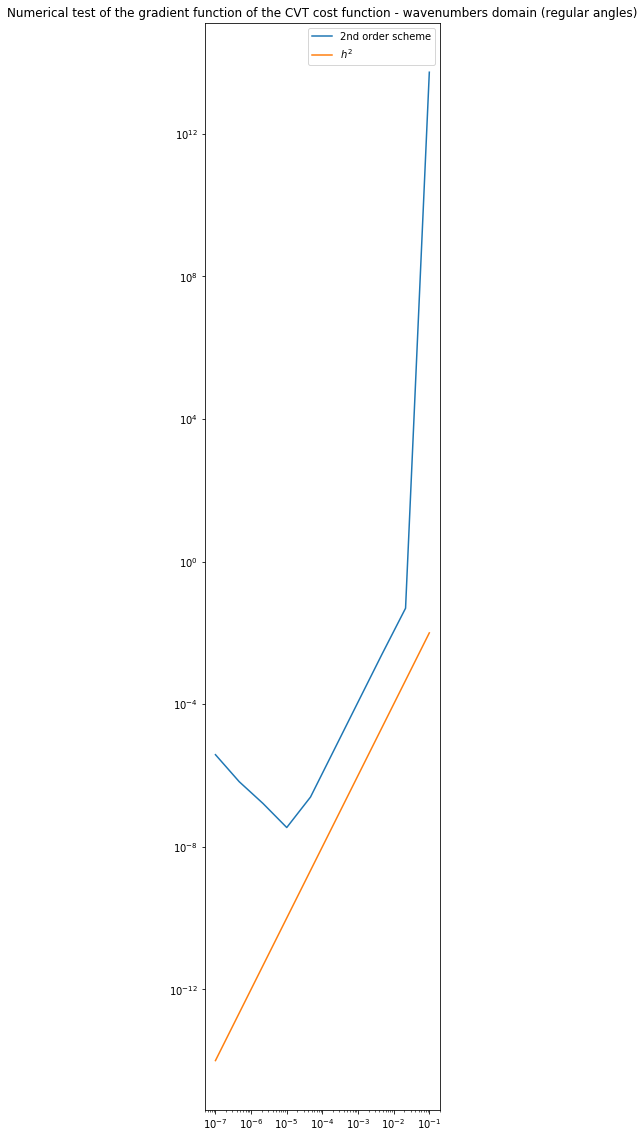

In [14]:
title = "Numerical test of the gradient function of the CVT cost function - wavenumbers domain (regular angles)"
plot_gradient_error(F, grad_F, K, args = (Domain,), title = title)

## Wavenumbers cost function

In [15]:
#shift = 0.5*phi_max/n
Phi_random = np.random.uniform(-phi_max, phi_max, size = n + m)
phiS_random = Phi_random[:m]
phiR_random = Phi_random[m:]

# Choose which acquisition to select as initialization
Phi = Phi_random

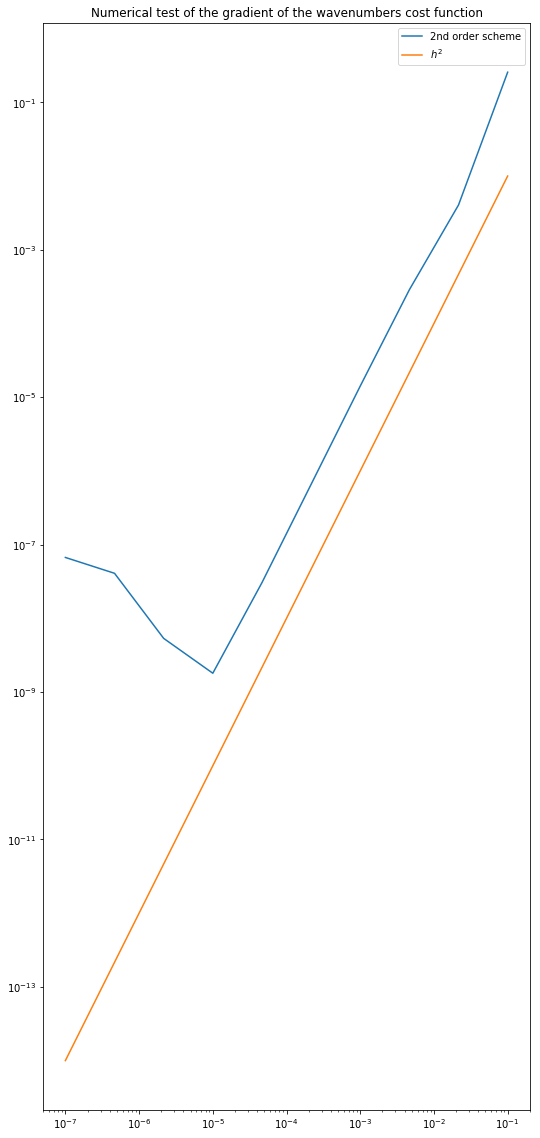

In [16]:
title = "Relative errors of $ \nabla F_{\phi}$ with schemes - random angles"
plot_gradient_error(FoK, grad_FoK, Phi, args = (Domain, c0, f0, m), title = title)